In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import collections
import csv
import re

In [3]:
#upload the data file 
file_name = 'enron-event-history-all.csv'
enron_data = pd.read_csv(file_name, names = ['time', 'message identifier', 'sender', 'recipients','topic', 'mode'], header=None)

#convert all string to be lower case, because there are same name not in the same format
enron_data = enron_data.applymap(lambda s:s.lower() if type(s) == str else s)
#drop columns after investigation
enron_data = enron_data.drop(columns=['message identifier', 'topic', 'mode'])
#convert time form milliseconds to datetime
enron_data['time'] = enron_data['time'].apply(lambda x: time.gmtime(x/1000.))
enron_data = enron_data.dropna(axis=0,how='any')
enron_data.head(10)


,time,sender,recipients
0,"(1998, 5, 27, 22, 31, 0, 2, 147, 0)",christopher behney,toni p schulenburg|mary hain
1,"(1998, 10, 30, 23, 43, 0, 4, 303, 0)",mark legal taylor,marc.r.cutler@bankamerica.com
2,"(1998, 10, 30, 23, 56, 0, 4, 303, 0)",mark legal taylor,marc.r.cutler@bankamerica.com
3,"(1998, 10, 31, 0, 2, 0, 5, 304, 0)",mark legal taylor,shari stack
4,"(1998, 10, 31, 1, 6, 0, 5, 304, 0)",mark legal taylor,marc.r.cutler@bankamerica.com
5,"(1998, 11, 3, 3, 32, 0, 1, 307, 0)",mark legal taylor,yao apasu
6,"(1998, 11, 3, 19, 12, 0, 1, 307, 0)",yao apasu,brent hendry|mark legal taylor
7,"(1998, 11, 4, 18, 31, 0, 2, 308, 0)",mark legal taylor,marc.r.cutler@bankamerica.com
8,"(1998, 11, 4, 19, 59, 0, 2, 308, 0)",mark legal taylor,paul simons
9,"(1998, 11, 5, 1, 3, 0, 3, 309, 0)",mark legal taylor,cynthia c sandherr@enron|jeffrey keeler@enron|...


In [4]:
def clean_email(s1):
    # remove @email address
    s1 = s1.split('@')[0]
    #replace special char with space
    s1 = re.sub('[^A-Za-z0-9]+', ' ', s1)
    #remove all prefix and suffix space
    s1 = s1.strip(' ')
    return s1

def process_person_count(df):
    person_count={}
    for idx,row in df.iterrows():    
        person = clean_email(row[1])
        
        #sender
        if person not in person_count:
            person_count[person] = [1,0]
        else:
            #old_count = 
            person_count[person] = [person_count[person][0]+1,person_count[person][1]]

        # recepients
        recepients = row[2].split('|')
        # print(recipients)
        for recepient in recepients:
            recepient= clean_email(recepient)
            if recepient not in person_count:
                person_count[recepient] = [0,1]
            else:
                person_count[recepient] = [person_count[recepient][0],person_count[recepient][1]+1]
    return person_count

def write_csv(df):
    # writes the dictionary to the output
    with open('contact.csv', mode='w',newline='') as contact:
        contact_writer = csv.writer(contact, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        contact_writer.writerow(['person','sent','received'])
        for person in df.index:
            contact_writer.writerow([person,person_count[person][0] ,person_count[person][1]])
        

In [5]:
person_count = process_person_count(enron_data)


In [6]:
df = pd.DataFrame.from_dict(person_count, orient='index',columns = ['sent','received'])
df.index.names = ['person']
df.head(10)

,sent,received
person,,
christopher behney,1,0
toni p schulenburg,0,1
mary hain,391,424
mark legal taylor,519,183
marc r cutler,0,35
shari stack,74,227
yao apasu,4,49
brent hendry,168,669
paul simons,59,214


In [7]:
sort_by_sent = df.sort_values('sent',ascending=False)
sort_by_sent.head(10)

,sent,received
person,,
jeff dasovich,5232,2249
sara shackleton,4591,5217
pete davis,3898,853
chris germany,3703,1591
notes,3314,1023
vince kaminski,2937,3046
matthew lenhart,2832,448
debra perlingiere,2611,469
gerald nemec,2353,3301


In [9]:
write_csv(sort_by_sent)

In [10]:
topNSender = sort_by_sent.index[0:5]
topNSender

Index(['jeff dasovich', 'sara shackleton', 'pete davis', 'chris germany',
       'notes'],
      dtype='object', name='person')

In [11]:
#get the sender over time
#get the time interval
time_count = (2002-1998+1)*12
def get_time():
    yearMonthly = []
    for i in range(time_count):
        year = i // 12 + 1998
        month = i % 12 + 1
        year = str(year)
        if month < 10:
            month = str(0) + str(month)
        else:
            month = str(month)
        yearMonthly.append(year+month)
    return yearMonthly

In [12]:
yearMonthly = get_time()

In [13]:
def sender_over_time(enron_data):
    SenderCountOverTime = {}
    for row in enron_data.iterrows():
        row_id, content = row
        times,sender,receiver = content
        if sender in topNSender:
            listOfreceiver = receiver.split("|")
           
            countOverTime = {}
            formatTime = time.strftime('%m/%d/%Y %H:%M:%S',  times)
            month,day,yearandtime = formatTime.split("/")
            year, exactTime = yearandtime.split(" ")

            index = (int(year) - 1998)*12 + int(month)
            if not sender in SenderCountOverTime.keys():
                templist = [0]*time_count
                templist[index] = len(listOfreceiver)
                SenderCountOverTime[sender] = templist[:]
            else:   
                templist[index] = SenderCountOverTime[sender][index] + len(listOfreceiver)                    
                SenderCountOverTime[sender] = templist[:]
    return SenderCountOverTime

In [14]:
SenderCountOverTime = sender_over_time(enron_data)

In [15]:
#get the receiver over time
def unique_received_count_over_time(enron_data):
    #define the time interval
    yearHafly = {'f1998':0,'s1998':1,'f1999':2,'s1999':3,'f2000':4,'s2000':5,'f2001':6,'s2001':7,'f2002':8,'s2002':9}
    
    trackingunique = {}
    uniqueReceivedCountOverTime = {}

    for row in enron_data.iterrows():
        row_id, content = row
    #    print(row_id)
        times,sender,receiver = content         
        formatTime = time.strftime('%m/%d/%Y %H:%M:%S', times)
        month,day,yearandtime = formatTime.split("/")
        year, exactTime = yearandtime.split(" ")
        countreceiver = 0
        listOfreceiver = receiver.split("|")
        if int(month) < 6:
            #first half year
            haflyCount =  str("f") + str(year)
        else:
            #second half year
            haflyCount =  str("s") + str(year)
        index = yearHafly.get(haflyCount)
        while countreceiver < len(listOfreceiver):
            preceiver = listOfreceiver[countreceiver]
            
            #clean the email to remove other charaters and only keep names
            preceiver = clean_email(preceiver)
            if preceiver in topNSender:
                timeAndSender = str(preceiver) + str(sender) + str(haflyCount)
                if not timeAndSender in trackingunique.keys():
                    trackingunique[timeAndSender] = 1                     
                    if not preceiver in uniqueReceivedCountOverTime.keys():
                        tempor = [0,0,0,0,0,0,0,0,0,0]
                        tempor[index] = 1
                        uniqueReceivedCountOverTime[preceiver] = tempor
                    else:
                        uniqueReceivedCountOverTime[preceiver][index] += 1
                else:
                    trackingunique[timeAndSender] = 1
            countreceiver += 1
    
    return uniqueReceivedCountOverTime

In [16]:
SenderCountOverTime = sender_over_time(enron_data)

In [17]:
uniqueReceivedCountOverTime = unique_received_count_over_time(enron_data)

In [18]:
#convert keys and values of dictionary to be lists
topNPersonSend = list(SenderCountOverTime.keys())
topNPersonSendCount = list(SenderCountOverTime.values())
topNPersonReceived = list(uniqueReceivedCountOverTime.keys())
topNPersonReceivedCount = list(uniqueReceivedCountOverTime.values())


Text(0,0.5,'Sending Count')

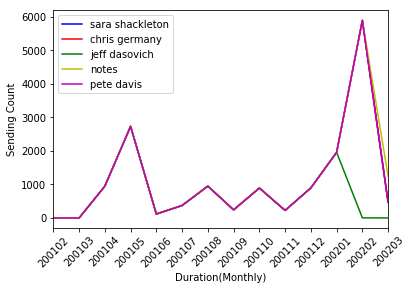

In [19]:
#plot sending count
sendingFigure = plt.figure("Sending Email Count Monthly")
plt.figure(1, figsize = (8.5,11))
axes = plt.gca()
plt.xticks(range(time_count), yearMonthly, rotation=45)
axes.set_xlim([37,50])
plt.plot(range(time_count), topNPersonSendCount[0], 'b-', label = topNPersonReceived[0])
plt.plot(range(time_count), topNPersonSendCount[1], 'r-', label = topNPersonReceived[1])
plt.plot(range(time_count), topNPersonSendCount[2], 'g-', label = topNPersonReceived[2])
plt.plot(range(time_count), topNPersonSendCount[3], 'y-', label = topNPersonReceived[3])
plt.plot(range(time_count), topNPersonSendCount[4], 'm-', label = topNPersonReceived[4])
plt.legend()
plt.xlabel('Duration(Monthly)')
plt.ylabel('Sending Count')

Text(0,0.5,'Receiving Count')

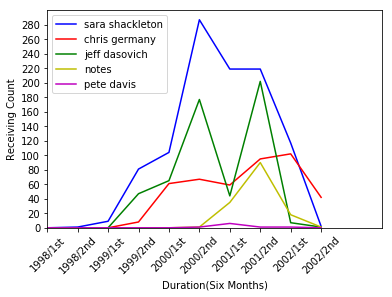

In [20]:
#set the time interval names
xAxisName = ['1998/1st','1998/2nd','1999/1st','1999/2nd','2000/1st','2000/2nd','2001/1st','2001/2nd','2002/1st','2002/2nd']
#plot receiving count
receivingFigure = plt.figure("Unique Email Receiving Count For Each Six Months")
plt.figure(1, figsize = (10,14))
axes = plt.gca()
axes.set_xlim([0,11])
axes.set_ylim([0,300])
yticks = np.arange(0, 300, 20)
plt.xticks(range(10), xAxisName, rotation = 45)
plt.yticks(yticks)
plt.plot(range(10), topNPersonReceivedCount[0], 'b-', label = topNPersonReceived[0])
plt.plot(range(10), topNPersonReceivedCount[1], 'r-', label = topNPersonReceived[1])
plt.plot(range(10), topNPersonReceivedCount[2], 'g-', label = topNPersonReceived[2])
plt.plot(range(10), topNPersonReceivedCount[3], 'y-', label = topNPersonReceived[3])
plt.plot(range(10), topNPersonReceivedCount[4], 'm-', label = topNPersonReceived[4])
plt.legend()
plt.xlabel('Duration(Six Months)')
plt.ylabel('Receiving Count')

In [21]:
#save the pics
receivingFigure.savefig("Unique Email Receiving Count For Each Six Months", dpi=100)
sendingFigure.savefig("Sending Email Count Monthly", dpi=100)